# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 69084.17 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 97966.56 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 118009.73 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 130341.78 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 138109.93 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 145557.72 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 70063.04 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 102981.52 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 115364.05 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 117574.86 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 143217.86 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.46 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.05 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 38.02 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.67 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 51.56 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.89 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.04 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.51 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.34 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.78 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.43 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.05 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.17 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.29 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.01 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.79 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.89 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.89 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.57 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.72 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.75 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.87 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.12 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 47.73 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.73 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.92 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.20 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.23 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.33 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 36.11 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.63 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.97 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.73 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.67 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 44.47 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 46.60 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 46.23 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.24 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.47 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.34 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.34 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.32 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.45 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.50 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.41 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.39 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.33 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.63 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 36.93 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.90 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.09 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.06 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.46 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.60 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.93 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.51 examples/s]

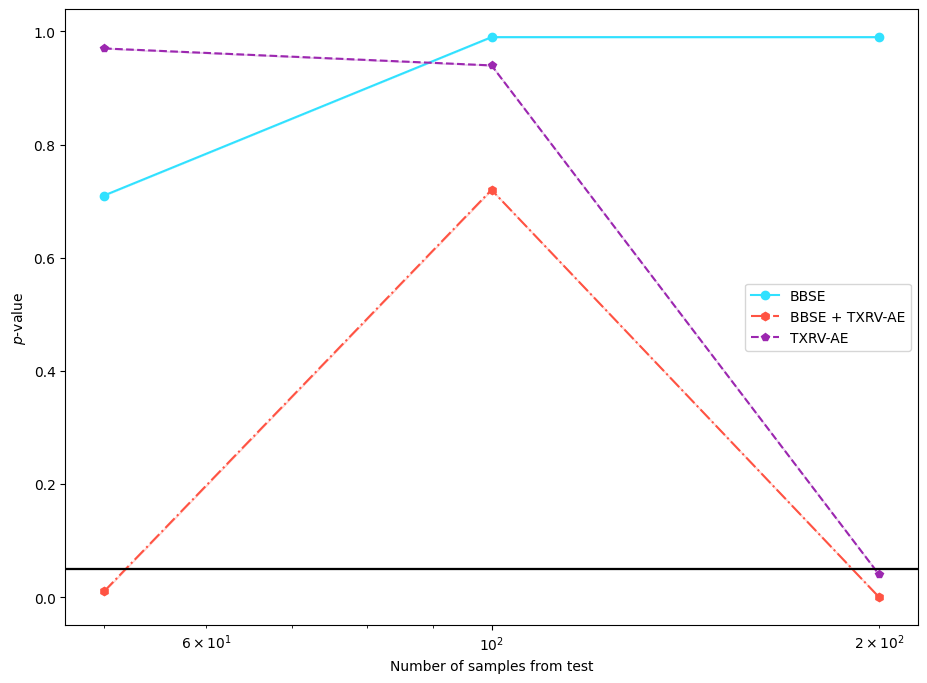

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.28 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.77 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.99 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.28 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.25 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.21 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.64 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.86 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.54 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.52 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.81 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.23 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.16 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.82 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.45 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.04 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.43 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.84 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.56 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.56 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.20 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.48 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.53 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.88 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.95 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.72 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.07 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.88 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.80 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.80 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.74 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.79 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.25 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.59 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.03 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.68 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.33 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.60 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.45 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.24 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.94 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.94 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.82 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.34 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.01 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.22 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.13 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.17 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.43 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.11 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.40 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.81 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.10 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.03 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.77 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.84 examples/s]

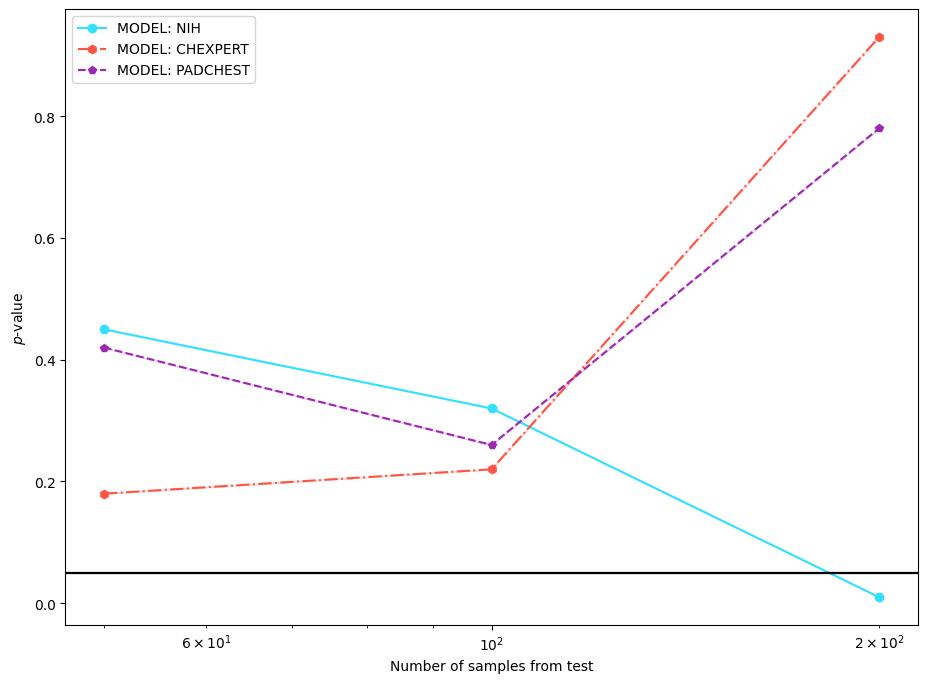

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54756.58 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 75206.96 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 92790.73 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 104766.93 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 111481.30 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 116097.49 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52286.35 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76355.01 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94387.85 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 106075.71 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 114996.33 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 121823.76 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.72 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.52 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.15 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.69 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.23 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.05 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.46 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.81 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.95 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.91 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.61 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.88 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.07 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.20 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.36 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.65 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.76 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.59 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.06 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53033.76 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 76056.86 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90267.85 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101024.50 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 107429.58 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 115506.58 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55373.29 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81218.18 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 95876.83 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102217.04 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 109105.02 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 114080.42 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.63 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.52 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.02 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.57 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.29 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.24 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.63 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.07 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.65 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.80 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.64 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.28 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.86 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.59 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.45 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.32 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.97 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.76 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.39 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52975.97 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 75906.23 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90897.18 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 101935.70 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 112054.77 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 116722.35 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52248.98 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 70934.49 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 80947.06 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 94015.68 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103403.10 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110643.94 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.63 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.61 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.91 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.59 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.81 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 58.05 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.57 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.94 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.11 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.41 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.89 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.82 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.43 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.89 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.01 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.69 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.66 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.55 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.24 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56366.33 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 82825.80 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 100504.32 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 108257.86 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 111943.86 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 116336.20 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 58067.09 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 82359.08 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 96871.81 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 105555.19 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 112038.67 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 118056.03 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.42 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.94 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.34 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.37 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.24 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.97 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.89 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.84 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.04 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.61 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.16 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.16 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.23 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.46 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.90 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.90 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.15 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.47 examples/s]

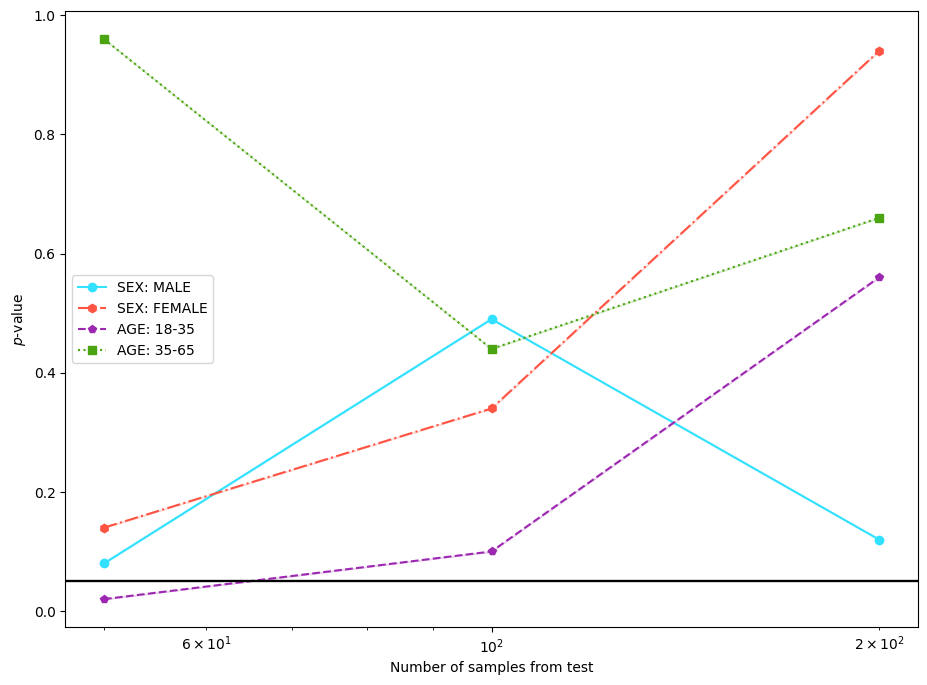

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.62 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.03 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.84 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.87 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.42 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.15 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.17 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.45 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.12 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.51 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.12 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.26 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.08 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.83 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.83 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.04 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.04 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.12 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.87 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.06 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.89 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.47 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.71 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.32 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.61 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.40 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.47 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.71 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.75 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.37 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.67 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.15 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.78 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.77 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.66 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.29 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.29 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.57 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 18.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.10 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.35 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.41 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.56 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.40 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.87 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.47 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.97 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.28 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.94 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.44 examples/s]

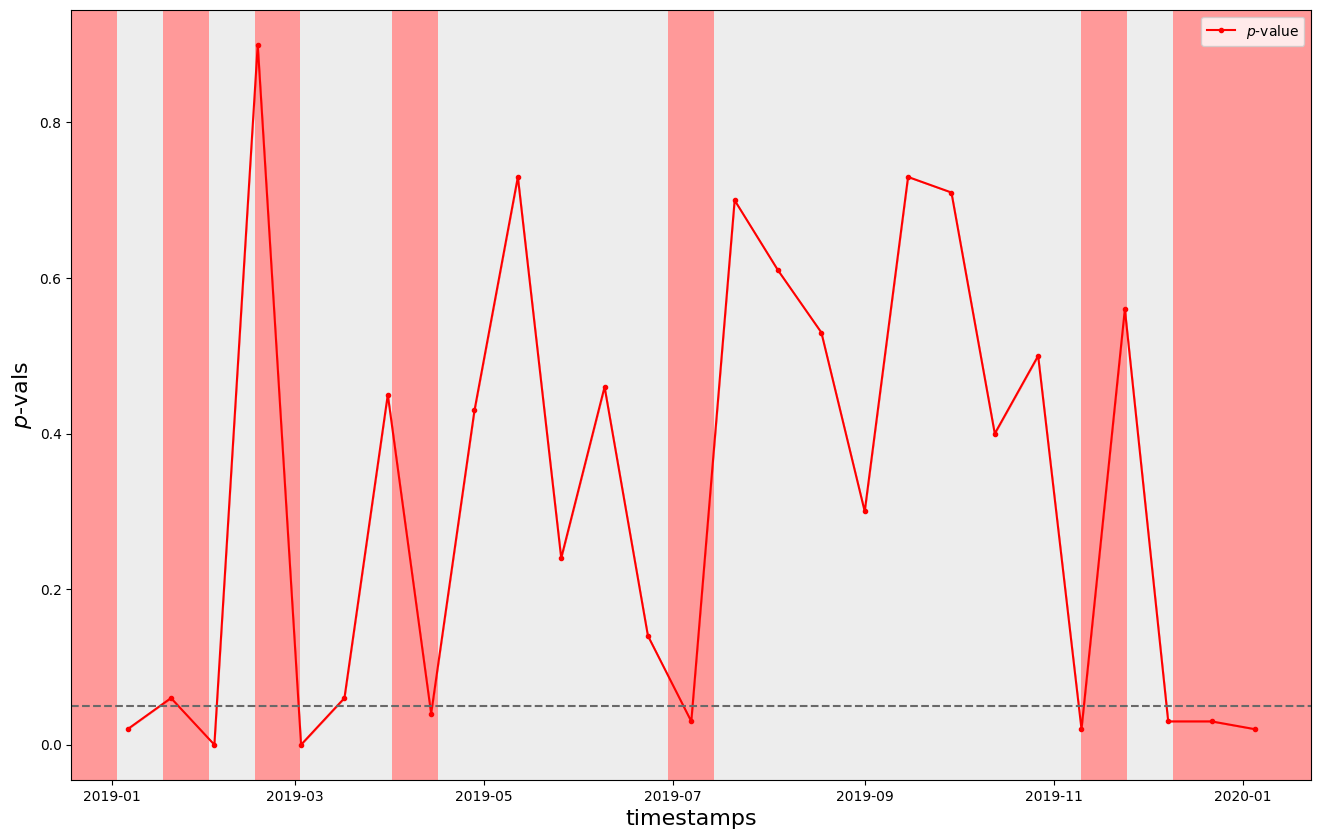

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)